In [1]:
import tensorflow as tf

In [2]:
import matplotlib.pyplot as plt
plt.rc('font',size=14)
plt.rc('axes',labelsize=14,titlesize=14)
plt.rc('legend',fontsize=14)
plt.rc('xtick',labelsize=10)
plt.rc('ytick',labelsize=10)


In [3]:
# import pathlib as Path

# Basic RNN

In [4]:
from pathlib import Path
filepath = tf.keras.utils.get_file(
    "ridership.tgz",
    "https://github.com/ageron/data/raw/main/ridership.tgz",
    cache_dir=".",
    extract=True
)
filepath_path = Path(filepath)
if "_extracted" in filepath:
    ridership_path = filepath_path / "ridership"
else:
    ridership_path = filepath_path.with_name("ridership")

108512/108512 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# Loading Data


In [5]:
import pandas as pd

In [6]:
path = Path("/content/datasets/ridership_extracted/ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv")
df= pd.read_csv(path,parse_dates=['service_date'])

In [7]:
df.head()

,service_date,day_type,bus,rail_boardings,total_rides
0,2001-01-01,U,297192,126455,423647
1,2001-01-02,W,780827,501952,1282779
2,2001-01-03,W,824923,536432,1361355
3,2001-01-04,W,870021,550011,1420032
4,2001-01-05,W,890426,557917,1448343


In [8]:
df.columns = ["date","day_type","bus","rail","total"]
df = df.sort_values("date").set_index("date") # sort the values and set date as the index

In [9]:
df = df.drop("total",axis=1)  # total = bus + rail so It is not needed

In [10]:
df = df.drop_duplicates()

In [11]:
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


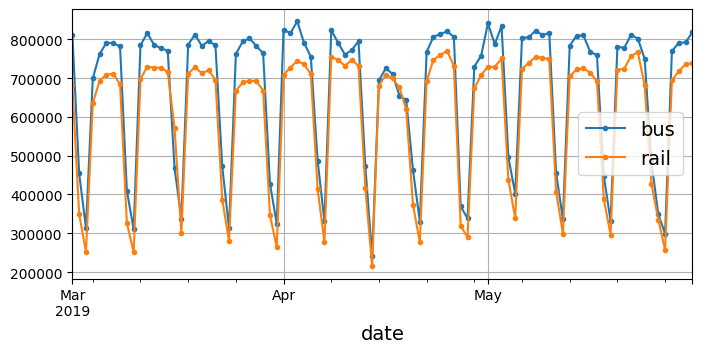

In [12]:
import matplotlib.pyplot as plt

df["2019-03":"2019-05"].plot(grid=True,marker=".",figsize=(8,3.5))
plt.show()

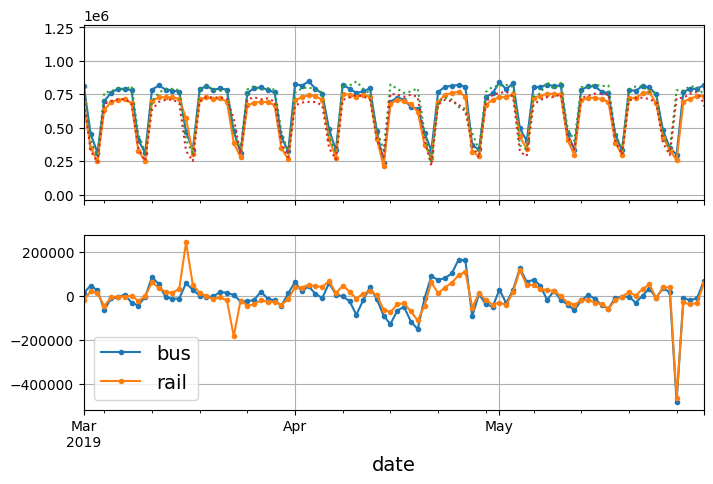

In [13]:
diff_7 = df[["bus", "rail"]].diff(7)["2019-03":"2019-05"]

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 5))
df.plot(ax=axs[0], legend=False, marker=".")  # original time series
df.shift(7).plot(ax=axs[0], grid=True, legend=False, linestyle=":")  # lagged
diff_7.plot(ax=axs[1], grid=True, marker=".")  # 7-day difference time series
# axs[0].set_ylim([170_000, 900_000])  # extra code – beautifies the plot
# extra code – saves the figure for the book
plt.show()

In [14]:
list(df.loc["2019-05-25":"2019-05-27"]["day_type"])

['A', 'U', 'U']

In [15]:
diff_7.abs().mean()

,0
bus,43915.608696
rail,42143.271739


In [16]:
targets = df[["bus", "rail"]]["2019-03":"2019-05"]
(diff_7 / targets).abs().mean()

,0
bus,0.082938
rail,0.089948


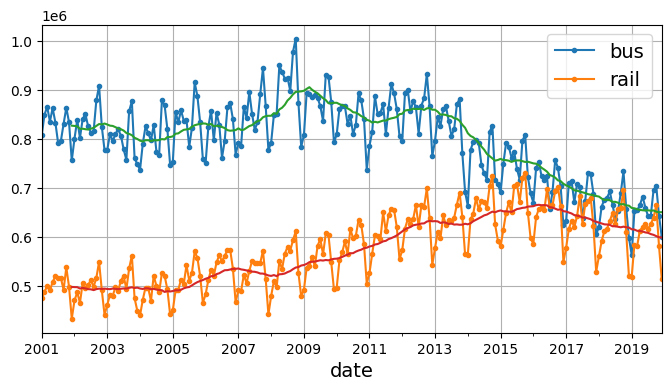

In [17]:
period = slice("2001", "2019")
df_monthly = df.drop('day_type', axis=1).resample('ME').mean() # compute the mean for each month
rolling_average_12_months = df_monthly[period].rolling(window=12).mean()
fig, ax = plt.subplots(figsize=(8, 4))
df_monthly[period].plot(ax=ax, marker=".")
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)
plt.show()

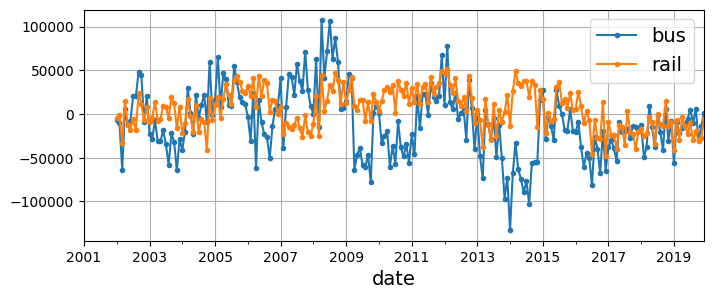

In [18]:
df_monthly.diff(12)[period].plot(grid=True, marker=".", figsize=(8, 3))
plt.show()

# ARIMA Model

In [19]:
import statsmodels

In [20]:
from statsmodels.tsa.arima.model import ARIMA

In [21]:
origin,today = "2019-01-01","2019-01-31"
rail_series = df.loc[origin:today]["rail"].asfreq("D")
model = ARIMA(rail_series,
              order=(1,0,0),
              seasonal_order=(0,1,1,7))
model = model.fit()
y_pred = model.forecast()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


In [22]:
y_pred

,0
2019-02-01,283604.715355


In [23]:
origin,start_date,end_date = "2019-01-01","2019-03-01","2019-05-31"
time_period = pd.date_range(start_date,end_date)
rail_series=df.loc[origin:end_date]["rail"].asfreq("D")
y_preds=[]
for today in time_period.shift(-1):
  model = ARIMA(rail_series[origin:today],order=(1,0,0),seasonal_order=(0,1,1,7))
  model= model.fit()
  y_pred = model.forecast().iloc[0]
  y_preds.append(y_pred)

In [24]:
y_preds=pd.Series(y_preds,index=time_period)
mae = (y_preds-rail_series[time_period]).abs().mean()

In [25]:
mae

np.float64(32040.720094289627)

# Preparing the Data for Machine Learning Models


In [26]:
my_series = [0,1,2,3,4,5]
my_dataset = tf.keras.utils.timeseries_dataset_from_array(
    my_series,
    targets = my_series[3:],
    sequence_length=3,
    batch_size=2
)

In [27]:
list(my_dataset)

[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[0, 1, 2],
         [1, 2, 3]], dtype=int32)>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([3, 4], dtype=int32)>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[2, 3, 4]], dtype=int32)>,
  <tf.Tensor: shape=(1,), dtype=int32, numpy=array([5], dtype=int32)>)]

In [28]:
for window_dataset in tf.data.Dataset.range(6).window(4,shift=1,drop_remainder=True):
  for element in window_dataset:
    print(f"{element}",end=" ")
  print()

0 1 2 3 
1 2 3 4 
2 3 4 5 


In [29]:
# Making tensor out of flat_map()
dataset = tf.data.Dataset.range(6).window(4,shift=1,drop_remainder=True)
dataset = dataset.flat_map(lambda window_dataset: window_dataset.batch(4))
for window_tensor in dataset:
  print(f"{window_tensor}")

[0 1 2 3]
[1 2 3 4]
[2 3 4 5]


In [30]:
def to_window(dataset,length):
  dataset= dataset.window(length,shift=1,drop_remainder=True)
  return dataset.flat_map(lambda window_ds: window_ds.batch(length))

In [31]:
dataset = to_window(tf.data.Dataset.range(6),4)
dataset = dataset.map(lambda window: (window[:-1],window[-1]))
list(dataset.batch(2))

[(<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
  array([[0, 1, 2],
         [1, 2, 3]])>,
  <tf.Tensor: shape=(2,), dtype=int64, numpy=array([3, 4])>),
 (<tf.Tensor: shape=(1, 3), dtype=int64, numpy=array([[2, 3, 4]])>,
  <tf.Tensor: shape=(1,), dtype=int64, numpy=array([5])>)]

In [32]:
rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06":] / 1e6

In [33]:
seq_length  = 56
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets = rail_train[seq_length:],
    sequence_length = seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)

valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets = rail_valid[seq_length:],
    sequence_length = seq_length,
    batch_size=32
)

# Forecasting using a model

In [34]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1,input_shape=[seq_length])
])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae",patience=50,restore_best_weights=True
)
opt = tf.keras.optimizers.SGD(learning_rate=0.02,momentum=0.9)

model.compile(loss = tf.keras.losses.Huber(),optimizer=opt,metrics=["mae"])

history = model.fit(train_ds,validation_data=valid_ds,epochs=500,callbacks=[early_stopping_cb])

Epoch 1/500


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1217 - mae: 0.3916 - val_loss: 0.0151 - val_mae: 0.1465
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0139 - mae: 0.1331 - val_loss: 0.0093 - val_mae: 0.1056
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0096 - mae: 0.1072 - val_loss: 0.0081 - val_mae: 0.0973
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0089 - mae: 0.1017 - val_loss: 0.0070 - val_mae: 0.0872
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0076 - mae: 0.0920 - val_loss: 0.0066 - val_mae: 0.0844
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0075 - mae: 0.0918 - val_loss: 0.0058 - val_mae: 0.0777
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0063 - mae: 0.0822 - val_loss: 0.0054 - val_mae: 0.0737
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0059 - mae: 0.0789 - val_loss: 0.0052 - val_mae: 0.0728
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0058 - mae: 0.

In [35]:
# Evaluate the model on the validation dataset
# The output is [loss_value, mae_value]
val_results = model.evaluate(valid_ds)

# The metrics are returned in the order defined in model.compile (loss, mae)
val_loss = val_results[0]
val_mae = val_results[1]

print(f"Final Validation Loss (Huber): {val_loss:.4f}")
print(f"Final Validation MAE: {val_mae:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0019 - mae: 0.0393
Final Validation Loss (Huber): 0.0022
Final Validation MAE: 0.0376


# Forecasting using RNN

In [36]:
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(1,input_shape=[None,1])
])
# This is Sequence to Vector RNN Model

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [37]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae",patience=50,restore_best_weights=True
)
opt = tf.keras.optimizers.SGD(learning_rate=0.02,momentum=0.9)

model.compile(loss = tf.keras.losses.Huber(),optimizer=opt,metrics=["mae"])

history = model.fit(train_ds,validation_data=valid_ds,epochs=500,callbacks=[early_stopping_cb])

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.4553 - mae: 0.8101 - val_loss: 0.0725 - val_mae: 0.3383
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0644 - mae: 0.3105 - val_loss: 0.0481 - val_mae: 0.2573
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0343 - mae: 0.1948 - val_loss: 0.0159 - val_mae: 0.1350
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0164 - mae: 0.1619 - val_loss: 0.0153 - val_mae: 0.1383
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0160 - mae: 0.1574 - val_loss: 0.0151 - val_mae: 0.1365
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0153 - mae: 0.1543 - val_loss: 0.0148 - val_mae: 0.1359
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0150 - mae: 0.1530 - val_loss: 0.0146 - val_mae: 0.1347
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0152 - mae: 0.1551 - val_loss: 0.0142 - val_mae: 0.1363
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - lo

In [38]:
# Evaluate the model on the validation dataset
# The output is [loss_value, mae_value]
val_results = model.evaluate(valid_ds)

# The metrics are returned in the order defined in model.compile (loss, mae)
val_loss = val_results[0]
val_mae = val_results[1]

print(f"Final Validation Loss (Huber): {val_loss:.4f}")
print(f"Final Validation MAE: {val_mae:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0099 - mae: 0.0987
Final Validation Loss (Huber): 0.0103
Final Validation MAE: 0.1028


In [39]:
univar_model = tf.keras.Sequential([
tf.keras.layers.SimpleRNN(32, input_shape=[None, 1]),
tf.keras.layers.Dense(1) # no activation function by default
])

In [40]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae",patience=50,restore_best_weights=True
)
opt = tf.keras.optimizers.SGD(learning_rate=0.02,momentum=0.9)

univar_model.compile(loss = tf.keras.losses.Huber(),optimizer=opt,metrics=["mae"])

history = univar_model.fit(train_ds,validation_data=valid_ds,epochs=500,callbacks=[early_stopping_cb])

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0400 - mae: 0.2149 - val_loss: 0.0057 - val_mae: 0.0855
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0060 - mae: 0.0789 - val_loss: 0.0029 - val_mae: 0.0524
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0046 - mae: 0.0611 - val_loss: 0.0029 - val_mae: 0.0529
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0039 - mae: 0.0574 - val_loss: 0.0032 - val_mae: 0.0586
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0037 - mae: 0.0576 - val_loss: 0.0025 - val_mae: 0.0470
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0039 - mae: 0.0560 - val_loss: 0.0033 - val_mae: 0.0604
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0035 - mae: 0.0531 - val_loss: 0.0022 - val_mae: 0.0394
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0039 - mae: 0.0533 - val_loss: 0.0022 - val_mae: 0.0380
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - lo

In [41]:
# Evaluate the model on the validation dataset
# The output is [loss_value, mae_value]
val_results = univar_model.evaluate(valid_ds)

# The metrics are returned in the order defined in model.compile (loss, mae)
val_loss = val_results[0]
val_mae = val_results[1]

print(f"Final Validation Loss (Huber): {val_loss:.4f}")
print(f"Final Validation MAE: {val_mae:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0013 - mae: 0.0267    
Final Validation Loss (Huber): 0.0017
Final Validation MAE: 0.0290


# Forecasting using a Deep RNN

In [42]:
import tensorflow as tf

In [43]:
deep_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
    ])

In [44]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae",patience=50,restore_best_weights=True
)
opt = tf.keras.optimizers.SGD(learning_rate=0.02,momentum=0.9)

deep_model.compile(loss = tf.keras.losses.Huber(),optimizer=opt,metrics=["mae"])

history = deep_model.fit(train_ds,validation_data=valid_ds,epochs=500,callbacks=[early_stopping_cb])


# Evaluate the model on the validation dataset
# The output is [loss_value, mae_value]
val_results = deep_model.evaluate(valid_ds)

# The metrics are returned in the order defined in model.compile (loss, mae)
val_loss = val_results[0]
val_mae = val_results[1]

print(f"Final Validation Loss (Huber): {val_loss:.4f}")
print(f"Final Validation MAE: {val_mae:.4f}")

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 0.1305 - mae: 0.3681 - val_loss: 0.0074 - val_mae: 0.1043
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0084 - mae: 0.0991 - val_loss: 0.0029 - val_mae: 0.0570
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0051 - mae: 0.0710 - val_loss: 0.0036 - val_mae: 0.0588
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0047 - mae: 0.0649 - val_loss: 0.0025 - val_mae: 0.0469
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0048 - mae: 0.0658 - val_loss: 0.0027 - val_mae: 0.0505
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0037 - mae: 0.0554 - val_loss: 0.0023 - val_mae: 0.0470
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0045 - mae: 0.0654 - val_loss: 0.0027 - val_mae: 0.0535
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0044 - mae: 0.0651 - val_loss: 0.0040 - val_mae: 0.0613
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - lo

# Forecasting Multivariate Time Series

In [45]:
df_mulvar = df[["bus","rail"]] / 1e6
df_mulvar["next_day_type"] = df["day_type"].shift(-1)
df_mulvar = pd.get_dummies(df_mulvar).astype(float)

In [46]:
df_mulvar.head()

,bus,rail,next_day_type_A,next_day_type_U,next_day_type_W
date,,,,,
2001-01-01,0.297192,0.126455,0.0,0.0,1.0
2001-01-02,0.780827,0.501952,0.0,0.0,1.0
2001-01-03,0.824923,0.536432,0.0,0.0,1.0
2001-01-04,0.870021,0.550011,0.0,0.0,1.0
2001-01-05,0.890426,0.557917,1.0,0.0,0.0


In [47]:
mulvar_train=df_mulvar["2016-01":"2018-12"]
mulvar_valid=df_mulvar["2019-01":"2019-05"]
mulvar_test=df_mulvar["2019-06":]

In [48]:
train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=mulvar_train["rail"][seq_length:],
    batch_size=32,
    shuffle=True,
    seed=42,
    sequence_length=seq_length
)
valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets = mulvar_valid["rail"][seq_length:],
    sequence_length = seq_length,
    batch_size = 32
)

In [49]:
def fit_and_evaluate(model,train_set,valid_set,learning_rate,epochs=500):
  early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_mae",patience=50,restore_best_weights=True)
  optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate,momentum=0.9)
  model.compile(loss=tf.keras.losses.Huber(),optimizer=optimizer,metrics=["mae"])
  history = model.fit(train_set,validation_data=valid_set,epochs=epochs,callbacks=[early_stopping_cb])
  valid_results = model.evaluate(valid_set)
  valid_mae = valid_results[1]
  return valid_mae*1e6

In [50]:
tf.random.set_seed(42)
mulvar_model=tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32,input_shape=[None,5]),
    tf.keras.layers.Dense(1)
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [51]:
fit_and_evaluate(mulvar_model,train_mulvar_ds,valid_mulvar_ds,learning_rate=0.05)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0898 - mae: 0.3091 - val_loss: 0.0029 - val_mae: 0.0602
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0030 - mae: 0.0572 - val_loss: 0.0013 - val_mae: 0.0416
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0017 - mae: 0.0409 - val_loss: 0.0017 - val_mae: 0.0516
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0018 - mae: 0.0419 - val_loss: 9.7403e-04 - val_mae: 0.0337
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0013 - mae: 0.0356 - val_loss: 0.0011 - val_mae: 0.0378
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0015 - mae: 0.0368 - val_loss: 0.0011 - val_mae: 0.0377
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0013 - mae: 0.0356 - val_loss: 6.6333e-04 - val_mae: 0.0257
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0012 - mae: 0.0341 - val_loss: 0.0013 - val_mae: 0.0414
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/s

22371.089085936546

# Forecasting Several Steps Ahead

In [59]:
import numpy as np

X= rail_valid.to_numpy()[np.newaxis, :seq_length,np.newaxis]
for step_ahead in range(14):
  y_pred_one = univar_model.predict(X)
  X=np.concatenate([X,y_pred_one.reshape(1,1,1)],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


In [ ]:
# This method is prefereable for few steps. If wrong prediction occurs it will affect all new predictions.

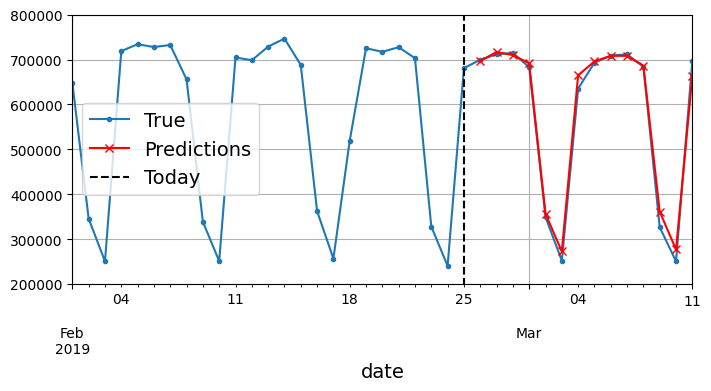

In [60]:
Y_pred = pd.Series(X[0, -14:, 0],
                   index=pd.date_range("2019-02-26", "2019-03-11"))

fig, ax = plt.subplots(figsize=(8, 3.5))
(rail_valid * 1e6)["2019-02-01":"2019-03-11"].plot(
    label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(
    label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines("2019-02-25", 0, 1e6, color="k", linestyle="--", label="Today")
ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
# save_fig("forecast_ahead_plot")
plt.show()

In [61]:
# RNN that predicts all 14 next values at once
def split_inputs_and_targets(mulvar_series, ahead=14, target_col=1):
    return mulvar_series[:, :-ahead], mulvar_series[:, -ahead:, target_col]

ahead_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32,
    shuffle=True,
    seed=42
).map(split_inputs_and_targets)
ahead_valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32
).map(split_inputs_and_targets)
